In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

In [42]:
users = pd.read_csv('takehome_users.csv', parse_dates=['creation_time'], encoding='latin1')
engagement = pd.read_csv('takehome_user_engagement.csv', parse_dates=['time_stamp'], encoding='latin1')

### **Data Cleaning**

In [43]:
users.drop_duplicates(subset='object_id', inplace=True)
engagement.drop_duplicates(inplace=True)

In [44]:
engagement['date'] = engagement['time_stamp'].dt.date

In [45]:
def label_adopted(df_eng, user_col='user_id', date_col='date'):
    grouped = df_eng.groupby(user_col)[date_col].apply(lambda x: sorted(pd.to_datetime(x).unique())).reset_index()
    
    def check_adopted(dates):
        if len(dates) < 3:
            return 0
        i = 0
        for j in range(len(dates)):
            while (dates[j] - dates[i]).days > 6:
                i += 1
            if j - i + 1 >= 3:
                return 1
        return 0
    
    grouped['adopted'] = grouped[date_col].apply(check_adopted)
    return grouped[[user_col, 'adopted']]

In [46]:
adopted_df = label_adopted(engagement, user_col='user_id', date_col='date')

In [47]:
users_labels = users.merge(adopted_df, left_on='object_id', right_on='user_id', how='left')
users_labels['adopted'] = users_labels['adopted'].fillna(0).astype(int)

### **Exploratory Data Analysis (EDA)**

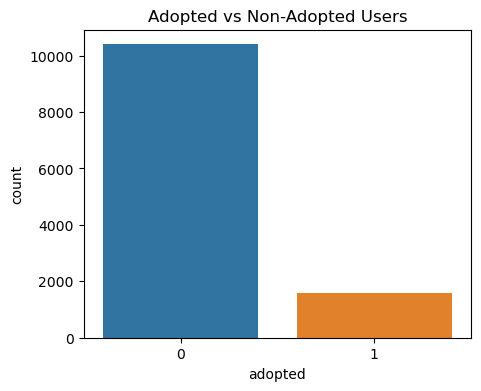

In [48]:
plt.figure(figsize=(5,4))
sns.countplot(x='adopted', data=users_labels)
plt.title('Adopted vs Non-Adopted Users')
plt.show()

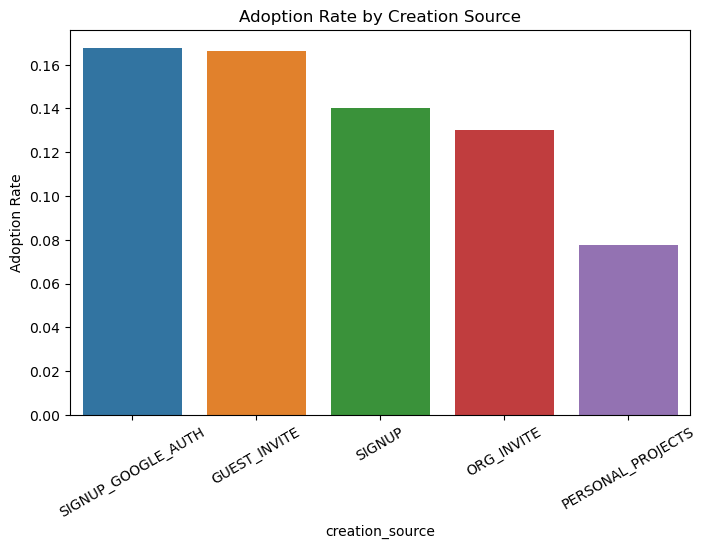

In [49]:
plt.figure(figsize=(8,5))
adoption_rate = users_labels.groupby('creation_source')['adopted'].mean().sort_values(ascending=False)
sns.barplot(x=adoption_rate.index, y=adoption_rate.values)
plt.ylabel("Adoption Rate")
plt.title("Adoption Rate by Creation Source")
plt.xticks(rotation=30)
plt.show()

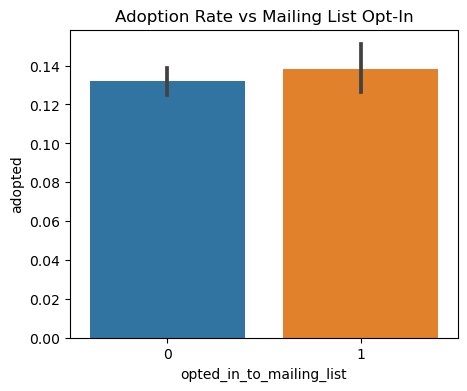

In [50]:
plt.figure(figsize=(5,4))
sns.barplot(x='opted_in_to_mailing_list', y='adopted', data=users_labels)
plt.title('Adoption Rate vs Mailing List Opt-In')
plt.show()

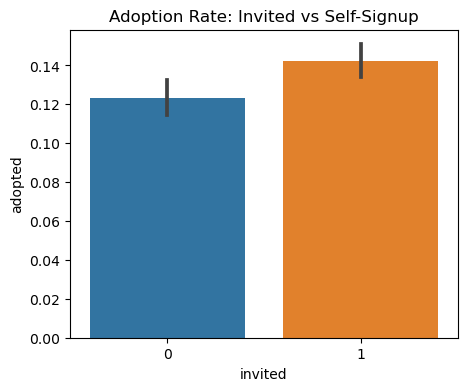

In [51]:
users_labels['invited'] = (~users_labels['invited_by_user_id'].isnull()).astype(int)
plt.figure(figsize=(5,4))
sns.barplot(x='invited', y='adopted', data=users_labels)
plt.title('Adoption Rate: Invited vs Self-Signup')
plt.show()

C:\Users\alana\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


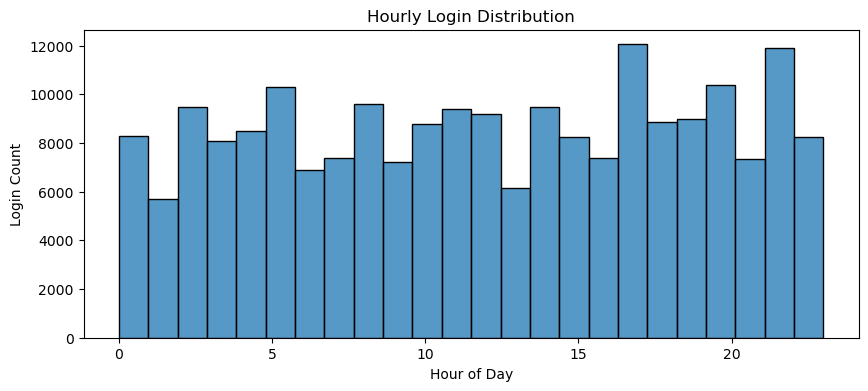

In [52]:
engagement['hour'] = engagement['time_stamp'].dt.hour
plt.figure(figsize=(10,4))
sns.histplot(data=engagement, x='hour', bins=24, kde=False)
plt.title("Hourly Login Distribution")
plt.xlabel("Hour of Day")
plt.ylabel("Login Count")
plt.show()

### **Feature Engineering**

In [53]:
df = users_labels.copy()

In [54]:
for col in ['opted_in_to_mailing_list','enabled_for_marketing_drip','invited']:
    df[col] = df[col].fillna(0).astype(int)

In [55]:
df['last_session_dt'] = pd.to_datetime(df['last_session_creation_time'], unit='s', errors='coerce')
df['days_since_last_session'] = (pd.Timestamp.now() - df['last_session_dt']).dt.days
df['days_since_last_session'].fillna(df['days_since_last_session'].median(), inplace=True)

In [56]:
df_model = pd.get_dummies(df[['opted_in_to_mailing_list','enabled_for_marketing_drip',
                              'invited','days_since_last_session','creation_source']], drop_first=True)
y = df['adopted']

### **Modeling**

In [57]:
X_train, X_test, y_train, y_test = train_test_split(df_model, y, test_size=0.2, stratify=y, random_state=42)

In [58]:
rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)
y_pred_proba = rf.predict_proba(X_test)[:,1]

### **Evaluation**

In [59]:
roc = roc_auc_score(y_test, y_pred_proba)
print("Random Forest ROC AUC:", round(roc,3))

Random Forest ROC AUC: 0.869


In [60]:
y_pred = rf.predict(X_test)
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Confusion Matrix:
 [[1891  189]
 [  97  223]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.91      0.93      2080
           1       0.54      0.70      0.61       320

    accuracy                           0.88      2400
   macro avg       0.75      0.80      0.77      2400
weighted avg       0.90      0.88      0.89      2400



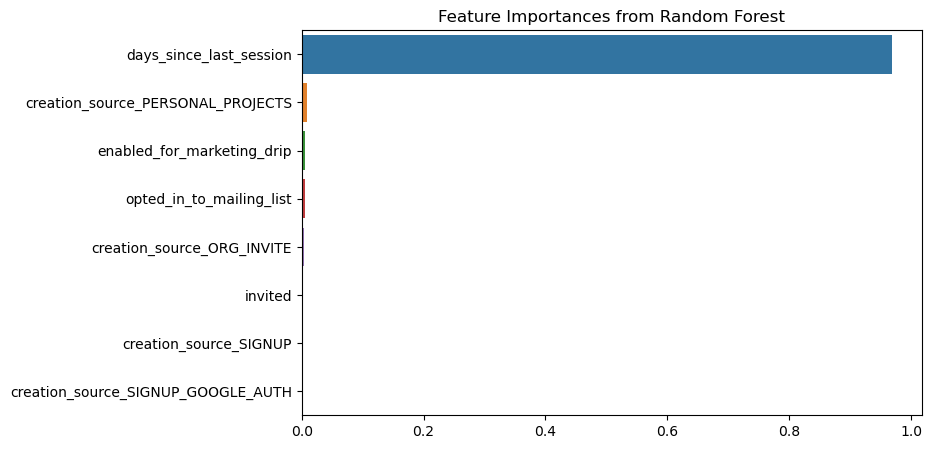

In [61]:
importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(x=importances.values, y=importances.index)
plt.title("Feature Importances from Random Forest")
plt.show()